In [16]:
# Author: Joshua Soutelo Vieira
# Date: 05/27/2021

EMNIST paper https://arxiv.org/pdf/1702.05373.pdf

The main goal of this script is to achieve the same resluting image (e) as shown in the banner. 
![https://www.kaggle.com/crawford/emnist](dataset-cover.png "Objective")

In [2]:
import os

import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
DATA_FOLDER = "data"
OUTPUT_FOLDER = "output"
OUTPUT_FOLDER_MANUAL_THRESH = "output_manual_thresh"

In [4]:
def grab_images(folder):
    paths = os.listdir(folder)
    return [f"{DATA_FOLDER}/{path}" for path in paths]

def show_image(image, name=None):
    plt.title(name)
    plt.xlabel(str(image.shape[1]) + " px")
    plt.ylabel(str(image.shape[0]) + " px")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

img_paths = grab_images(DATA_FOLDER)

**1. From RGB image to Black and White**

First of all we need to read the image with a grayscale image codec before apply the treshold function. This is achieved in the `cv2.imread` function. 

We make use of the Otsu algorithm `cv2.THRESH_OTSU` to find the optimal threshold value. 

Then, we use it in `cv2.THRESH_BINARY_INV` to perform the actual thresholding as dictates its equation:

$$ dst(x,y) = \left\{ \begin{array}{cl}
0 & : \ src(x,y) \gt tresh \\
maxval & : \ otherwise
\end{array} \right. $$

In [15]:
# Gray scale image + Tresholding => B&W image
def bw(image, threshold=None, show=False):
    # First transform the image to gray scale
    gray_img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    # Sometimes we choose to set the threshold manually assuming that the Otsu algorithm wasn't unable to find a proper one
    if threshold:
        (thresh, bw_img) = cv2.threshold(gray_img, threshold, 255, cv2.THRESH_BINARY_INV)
    else:
        # Treshold set to -0 to point out that it's Otsu's algorithm job to decide it
        (thresh, bw_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    if show:
        show_image(gray_img, "Gray scale")
        show_image(bw_img, "Trehshold (B&W)")
    
    return bw_img

**2. Perform Gaussian Blur over the B&W image**

We use a kernel of size 3x3 with a sigma of .5. 

The intuition behind the decission of the kernel size is that we had at most 40-50 dimensions in one axis of very few instances. So, choosing a bigger kernel would take into account the majority of the pixels of the image. 

And because images are so small already we needed a kernel that faded really quickly. So we have a bright spot in the middle, and almost faded spots surrounding it. Since only `sigmaX` is set, `sigmaY` takes it's same value.


In [6]:
# Gaussian Blur
def gauss_blur(image, show=False):
    
    gauss_img = cv2.GaussianBlur(
        src=image,
        ksize=(3,3),
        sigmaX=.5)
    
    if show: show_image(gauss_img, "Gaussian Blur")
    
    return gauss_img

**3. Region Of Interest Extraction**

The approach here was to compute the ROI in the B&W image and then apply the contours to the Gaussian blurred image.

Countours are founded using the `cv2.findContours`. The countour retrival mehtod is `cv2.RETR_EXTERNAL`, from the docs we see that it retrieves only the extreme outer contours. As for the contour aproximaton method we use `cv2.CHAIN_APPROX_NONE` that stores absolutely all the contour points.

The `if...else` inside the function controls if there is more than one rectagle found in the contours. That happens when the image is an "i". It finds a contour for the stick and a different one for the dot. When we face that situation we have to make a single extraction of the more adjusted coordinates of both contours.

The logic for that is:
1. Take the outer x or y position (the leftmost or upmost)
2. Advance by that amount
3. Add the difference between the bigger and the smaller one (x or y)
4. Add the width or height of the bigger coordinate

*Example.*
Imagine that we have this two rectangles `rects = [(5, 9, 5, 10), (6, 3, 3, 4)] #(x, y, w, h)`. We take the outmost x and y. So no we have that `y=3` and `x=5`. Now, we need to add the difference with the big corresponding coordinate and add its height or width.

In [7]:
# print(rects) [(5, 9, 5, 10), (6, 3, 3, 4)]
# x, y, w, h = rects[0]
# roi = gauss_img[y:y+h, x:x+w]
# roi = gauss_img[3:3+(6+10), 5:5+(1+4)]

# ROI Extraction
def roi(bw_img, gauss_img, cls, show=False):
    ctrs, hier = cv2.findContours(bw_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    #print(rects)
    if len(rects) == 1: # Only one contour found
        x, y, w, h = rects[0]
    elif len(rects) == 2 and (cls == 'i' or cls == '5'):
        x1, y1, w1, h1 = rects[0]
        x2, y2, w2, h2 = rects[1]
        y = min(y1, y2)
        # The distance between the two + the height of the contrary
        h = (y1 - y2 if y1 > y2 else y2 - y1) + (h1 if y != y1 else h2)
        x = min(x1, x2)
        # The distance between the two + the width of the contrary
        w = x1 - x2 if x1 > x2 else x2 - x1 + (w1 if x != x1 else w2)
    elif len(rects) == 2 and cls == '1':
        x1, y1, w1, h1 = rects[0]
        x2, y2, w2, h2 = rects[1]
        y = y1 if h1 > h2 else y2
        h = h1 if h1 > h2 else h2
        x = x1 if h1 > h2 else x2
        w = w1 if h1 > h2 else w2
        
    elif len(rects) == 3 and cls == '1':
        x, y, w, h = (0, 0, 0, 0)
        # Sets as valid the thicker one
        for r in rects:
            x1, y1, w1, h1 = r
            if w1 > w: x, y, w, h = r
    
    elif len(rects) == 4 and cls == '0':
        x, y, w, h = (0, 0, 0, 0)
        # Sets as valid the thicker one
        for r in rects:
            x1, y1, w1, h1 = r
            if w1 > w and h1 > h: x, y, w, h = r 
    else:
        # If it enters here, a new edge case was found...
        # I'm assuming that the biggest rectangle will always contain the true region of interest
        #print(rects)
        x, y, w, h = (0, 0, 0, 0)
        for r in rects:
            x1, y1, w1, h1 = r
            if w1 > w and h1 > h: x, y, w, h = r 
                
    roi = gauss_img[y:y+h, x:x+w]
    
    if show: show_image(roi, "ROI")
    
    return roi

**4. Padding and resizing the image** 

From the EMNIST paper we see that to obtain the final result they did:
1. Center the extracted region of interest in a square frame with lengths equal to the largest dimension, with the aspect ratio of the extracted region of interest preserved.
2. Pad this square frame with an empty 2 pixel border to prevent the digits and characters from touching the border.
3. Lastly, image is down-sampled to 28 × 28 pixels using a bi-cubic interpolation algorithm.

The scale is preserved when in the `cv2.resize` we use `fx=1` and `fy=1`. On the other hand, to upscale or downscale using a bi-cubic interpolation algorithm the `interpolation` flag is set to `cv2.INTER_CUBIC`.

In [12]:
def pad_resize(roi_img, show=False):
    # From EMNIST paper...
    
    # Extracted ROI centered in a square frame with lengths equal to the largest dimension
    h, w = roi_img.shape
    l_dim = max(h, w)
    bg_img = np.zeros((l_dim, l_dim)).astype('uint8')
    
    # Compute xoff and yoff for placement of upper left corner of resized image
    yoff = round((l_dim-h)/2)
    xoff = round((l_dim-w)/2)

    cent_img = bg_img.copy()
    cent_img[yoff:yoff+h, xoff:xoff+w] = roi_img
    if show: show_image(cent_img, "Centered")

    # Square frame padded with two empty pixels
    pad_img = cv2.copyMakeBorder(cent_img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, None, 0)
    if show: show_image(pad_img, "Padded")

    # Downscale or upscale https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/
    #res_img = cv2.resize(src=pad_img, dsize=(28,28), fx=1, fy=1, interpolation=cv2.INTER_CUBIC)
    res_img = cv2.resize(src=pad_img, dsize=(28,28), interpolation=cv2.INTER_CUBIC)
    if show: show_image(res_img, "Resized Image")
    
    return res_img

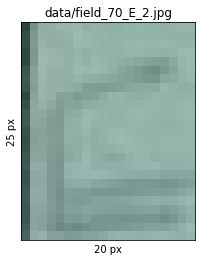

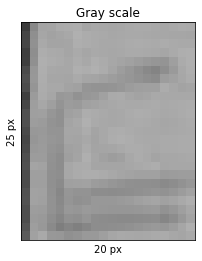

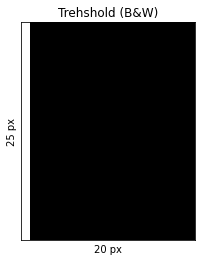

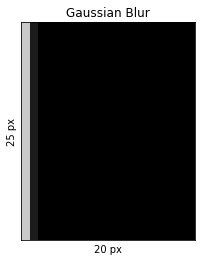

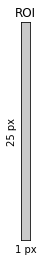

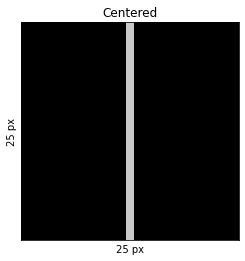

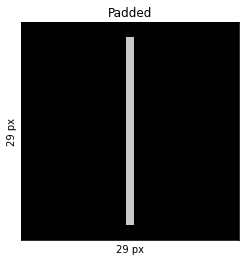

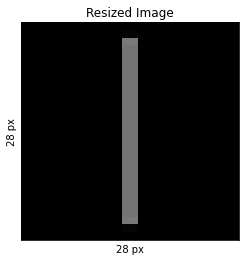

In [14]:
### Testing area ###

indx = [i for i, s in enumerate(img_paths) if "field_70_E" in s][0]
img_path = img_paths[indx]

img_name = img_path.split("/")[1]
cls = img_name.split("_")[0]

img = cv2.imread(img_path)
show_image(img, img_path)

bw_img = bw(img_path, show=True)
gauss_img = gauss_blur(bw_img, True)
roi_img = roi(bw_img, gauss_img, cls, True)
result = pad_resize(roi_img, True)

In [144]:
# Preprocessing loop
min_roi = {"px2": None, "shape": None, 'image':None}
for img_path in img_paths:
    img_name = img_path.split("/")[1]
    cls = img_name.split("_")[0]
    
    img = cv2.imread(img_path)
    bw_img = bw(img_path)
    gauss_img = gauss_blur(bw_img)
    print(img_name)
    roi_img = roi(bw_img, gauss_img, cls)
    result = pad_resize(roi_img)
    
    cv2.imwrite(f'{OUTPUT_FOLDER}/{img_name}',result)
    

field_75_A_2.jpg
field_178_1_25.jpg
field_45_0_3.jpg
field_23_4_1.jpg
field_182_7_13.jpg
field_127_7_8.jpg
field_126_7_7.jpg
field_141_h_1.jpg
field_13_6_0.jpg
field_10_S_1.jpg
field_42_8_0.jpg
field_63_W_3.jpg
field_27_a_0.jpg
field_73_7_4.jpg
field_87_2_2.jpg
field_84_N_2.jpg
field_107_I_3.jpg
field_145_9_3.jpg
field_33_3_1.jpg
field_5_L_0.jpg
field_146_9_4.jpg
field_188_1_27.jpg
field_117_T_4.jpg
field_131_5_6.jpg
field_2_S_0.jpg
field_59_I_2.jpg
field_155_0_12.jpg
field_8_T_0.jpg
field_65_M_0.jpg
field_32_1_2.jpg
field_151_2_11.jpg
field_191_5_16.jpg
field_152_5_10.jpg
field_179_5_13.jpg
field_169_2_13.jpg
field_109_1_9.jpg
field_142_I_4.jpg
field_119_4_5.jpg
field_164_1_19.jpg
field_79_6_5.jpg
field_24_6_1.jpg
field_21_1_1.jpg
field_61_5_3.jpg
field_36_1_3.jpg
field_1_3_0.jpg
field_28_V_0.jpg
field_67_K_0.jpg
field_116_3_7.jpg
field_176_5_12.jpg
field_158_1_17.jpg
field_38_L_2.jpg
field_22_0_1.jpg
field_3_W_0.jpg
field_97_4_3.jpg
field_180_2_14.jpg
field_64_W_4.jpg
field_52_1_5.jp

My thoughts on the images that aren't pre-processed properly...

*First case.*

Image cropped without enough padding. One example could be field_64_W_4.jpg. It complicates the ROI extraction, because it generates rectangles for each sliced part. And to put them back together  To fix this we could add more `if...else` trying to catch this edge cases, which is very time consuming. 


*Second case.* 

Image cropped along with form lines, being the latter more vivid than the actual character. One example could be field_137_0_9.jpg and field_153_1_16.jpg. This kind of instances confuse the Otsu algorithm to find an optimal threshold for the image. One possible fix to this could be set a fixed threshold value that do well for most of the images.